# Acknowledgements

Notebook developed by Andrew Ferguson for the UChicago course MENG15100: Machine Learning and Artificial Intelligence for Molecular Discovery and Engineering.

Components of these notebooks and code were borrowed and adapted from the [Data@PSL](https://github.com/data-psl) tutorials originally written by Pierre Ablin, Mathieu Blondel and Arthur Mensch under the [MIT License](https://github.com/data-psl/lectures2025/blob/main/LICENSE). Some materials therein were adapted from [sklearn tutorials](https://github.com/jakevdp/sklearn_tutorial/tree/master) developed by Jake Vanderplas under the [BSD-3 License](https://github.com/jakevdp/sklearn_tutorial/blob/master/LICENSE).

# Unsupervised Dimensionality Reduction w/ Principal Components Analysis (PCA)

Here we'll explore **Principal Components Analysis** as a simple and powerful linear dimensionality reduction technique.

## Data Exploration

First let's generate a 2D data set that is amenable to easy visualization and which we will use to motivate, understand, and conduct PCA.

In [1]:
from __future__ import print_function, division
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA

np.random.seed(42)

num_points = 500
mean = [0, 0]
cov = [[10, 0], [0, 0.3]]  # Stretch along x-axis (ellipse)
X = np.random.multivariate_normal(mean, cov, size=num_points)

theta = np.radians(30)  # Rotate the dataset to make PCA more illustrative
rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta),  np.cos(theta)]])
X = X @ rotation_matrix.T

print(X.shape)

(500, 2)


Now let's plot the data.

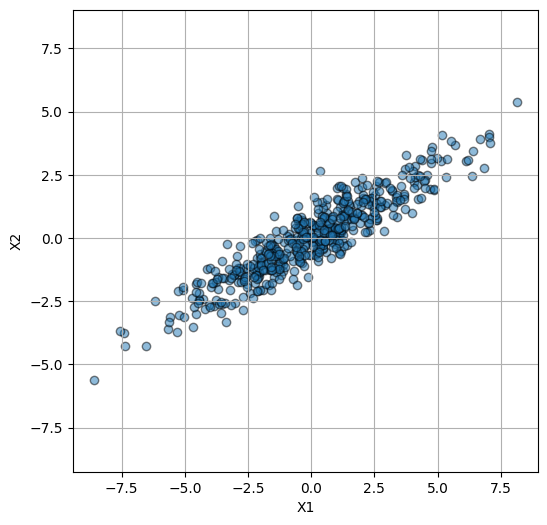

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], alpha=0.5, edgecolor='k')
plt.axis('equal')
plt.xlabel('X1')
plt.ylabel('X2')
plt.grid(True)
plt.show()

What do you notice about the data?
> * Is the data uniformly distributed, or does it have a particular shape?
* Is one direction in the data more important than another?
* Is the X1 component of the data more important than the X2 component?
* Is there another component that is a mix of X1 and X2 that is the most important?
* What do we mean by "important"?

## Variance

Let's compute the **variance** of the data set along the X1 and X2 directions. The variance is a mathematical concept that reports how spread out the data is along a particular direction.

Given some data point $\{x_i\}_{i=1}^N$, we can compute the **mean** as:

$\mu = \frac{1}{N}\sum_{i=1}^N x_i$

and the **variance** as:

$\sigma^2 = \frac{1}{N}\sum_{i=1}^N (x_i - \mu)^2$

The **standard deviation** $\sigma$ is just the square root of the variance.

In general, PCA should be applied to **mean-zeroed** data. This just means that we have to subtract out the mean from all of our features before we run PCA.

$X_k \leftarrow X_k - \mu_k$, where $\mu_k = \frac{1}{N}\sum_{i=1}^N X_k[i]$

Let's first check that our data are (approximately) mean zero.

In [ ]:
print('Mean(X1) = %.3f' % (np.mean(X[:, 0])))
print('Mean(X2) = %.3f' % (np.mean(X[:, 1])))

Mean(X1) = 0.000
Mean(X2) = 0.022


Now let's compute the variance along each feature.

In [ ]:
cov = np.cov(X.T)
print('Var(X1) = %.3f' % (cov[0, 0]))
print('Var(X2) = %.3f' % (cov[1, 1]))

Var(X1) = 7.125
Var(X2) = 2.521


Recall that we are in the **unsupervised learning** regime, so our data $X$ do not have any accompanying labels $y$. In the unsupervised regime, we do not have any concept of a predictive accuracy by which to define a loss function and fit a model.

> *It is the primary goal of PCA to find a lower-dimensional representation of the data that preserves the maximum amount of variance in the data.*

The underlying assumption of this objective is that more information is carried in elongated directions as opposed to squashed directions.

The "natural" way to represent our data is by the $X1$ and $X2$ features.

Let's take a quick look at the first few rows of the 2D $X = \{X1,X2\}$ data.

In [ ]:
print("           X1","         X2")
print(X[:10])

           X1          X2
[[ 1.39817297  0.71978952]
 [ 1.35666921  1.74652199]
 [-0.57713438 -0.4812899 ]
 [ 4.11468175  2.86098096]
 [-1.43429474 -0.48494536]
 [-1.14157627 -0.95364273]
 [ 1.18661435 -0.52497256]
 [-4.56989325 -2.99405096]
 [-2.85981243 -1.45236601]
 [-2.09995105 -2.10562659]]


Our data is 2D, meaning that each instance is represeted by two features $X1$ and $X2$.

* If we had to choose to represent the data in 1D using only a single feature, would you pick -- $X1$ or $X2$?
* Why?

This is the essence of dimensionality reduction\!

## Rotation

Can we do better than just picking $X1$ or $X2$ for our compressed 1D representation of the data?

**Yes!** In our data exploration above, we noted that there was a mixed direction containing a lot of $X1$ mixed in with a bit of $X2$ that defines a sloped or diagonal direction that looks like it may contain even more variance than $X1$ or $X2$.

Let's look into this further by trying to find some new directions that carry more variance. Graphically, we can do so by effectively **"tilting our head"** or **rotating the coordinate frame** to represent our data in a new rotated set of axes. We hypothesize that by passing one of our coordinate axes along the elongated aspect of the data might allow us to achieve a 1D representation preserving much more of the variance.

>Mathematically, we would like to **maximize the variance carried in each axis of the rotated frame**. This defines our PCA objective function that we seek to maximize: \\
> $L = \sum_i Var(PC_i)$, \\
> where $PC_i$ are the **principal components** defining the directions of our rotated axes.

Let's play with the Python GUI below to rotate the coordinate frame and try to maximize the variance carried along the rotated axes.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
import matplotlib

# Ensure clean plots in Colab
matplotlib.rcParams['figure.figsize'] = [6, 6]

# Interactive plot function
def plot_rotated_axes(theta_deg):
    theta = np.radians(theta_deg)
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                                [np.sin(theta),  np.cos(theta)]])

    # Unit vectors
    unit_vec1 = rotation_matrix[:, 0]
    unit_vec2 = rotation_matrix[:, 1]

    # Project data onto rotated unit vectors
    proj1 = X @ unit_vec1
    proj2 = X @ unit_vec2

    # Variances along rotated axes
    var1 = np.var(proj1)
    var2 = np.var(proj2)
    total_var = var1 + var2

    # Plot
    plt.figure()
    plt.scatter(X[:, 0], X[:, 1], alpha=0.3, edgecolor='k', label='Data')

    origin = np.mean(X, axis=0)
    scale = 5  # for visual length of arrows

    # Draw unit vectors
    arrow1 = unit_vec1 * scale
    arrow2 = unit_vec2 * scale
    plt.quiver(*origin, *arrow1, color='red', angles='xy', scale_units='xy', scale=1, label='PC1')
    plt.quiver(*origin, *arrow2, color='blue', angles='xy', scale_units='xy', scale=1, label='PC2')

    # Label variances next to each vector tip
    tip1 = origin + arrow1
    tip2 = origin + arrow2
    plt.text(tip1[0], tip1[1], f"Var(PC1) = {var1:.2f}", color='red', fontsize=10, ha='left', va='bottom')
    plt.text(tip2[0], tip2[1], f"Var(PC2) = {var2:.2f}", color='blue', fontsize=10, ha='left', va='bottom')

    # Total variance in bottom-right corner
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    plt.text(xmax - 2, ymin + 1, f"Total Variance: {total_var:.2f}",
             ha='right', va='bottom', fontsize=10, bbox=dict(facecolor='white', alpha=0.6))

    plt.title(f"Rotated Axes at θ = {theta_deg:.1f}°")
    plt.axis('equal')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.grid(True)
    plt.legend()
    plt.show()

# Slider widget
interact(plot_rotated_axes, theta_deg=FloatSlider(value=0, min=0, max=360, step=5, description='θ (degrees)'))

interactive(children=(FloatSlider(value=0.0, description='θ (degrees)', max=360.0, step=5.0), Output()), _dom_…

<function __main__.plot_rotated_axes(theta_deg)>

Graphically, we can see that $\theta$ is controlling the mixing between $X1$ and $X2$:

$PC1 = \cos(\theta) X1 + \sin(\theta) X2$

And since $PC2$ has to be **orthogonal** (i.e., at right angles to) $PC1$:

$PC2 = -\sin(\theta) X1 + \cos(\theta) X2$

What is the optimal rotation angle that places the most variance in PC1?

Store this value below.

In [ ]:
theta = 0.0

OK, now instead of keeping the *data fixed* and looking at our *rotated axes* move, let's flip the script and instead *keep the axes fixed* and *rotate the data*.

We will also report out next to the plot the coordinates of the data in the original coordinate frame ($X1,X2$) and in the rotated frame ($PC1,PC2$).

In the plot, we will show the 1D representation of the points in $PC1$ as dark blue crosses on the x-axis.

Remember, our objective is to preserve as much variance as possibel in $PC1$ so we want the projection of the points in $PC1$ to be as spread out as possible.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
import matplotlib
import pandas as pd
from IPython.display import display
import ipywidgets as widgets

# Ensure clean plots in Colab
matplotlib.rcParams['figure.figsize'] = [6, 6]

# Interactive plot function
def plot_rotated_axes(theta_deg):
    theta = np.radians(theta_deg)

    # Rotation matrix to rotate the data visually
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                                [np.sin(theta),  np.cos(theta)]])

    # Rotate data
    X_rotated = X @ rotation_matrix  # Rotate points

    # Compute variances in rotated frame
    var_pc1 = np.var(X_rotated[:, 0])
    var_pc2 = np.var(X_rotated[:, 1])

    # Prepare plot and table output widgets
    output_plot = widgets.Output()
    output_table = widgets.Output()

    with output_plot:
        plt.figure()

        # Plot rotated data points
        plt.scatter(X_rotated[:, 0], X_rotated[:, 1],
                    alpha=0.3, edgecolor='k', label='Rotated Data', color='skyblue')

        # Plot projection onto x-axis (PC1 axis)
        plt.scatter(X_rotated[:, 0], np.zeros_like(X_rotated[:, 0]),
                    alpha=0.6, label='Projections onto PC1', color='blue', marker='x',)

        # Draw vertical lines from points to their projections
        for x, y in X_rotated:
            plt.plot([x, x], [0, y], color='blue', alpha=0.1)

        # Variance info
        xmin, xmax = plt.xlim()
        ymin, ymax = plt.ylim()
        info_text = f"Var(PC1) = {var_pc1:.2f}\nVar(PC2) = {var_pc2:.2f}"
        plt.text(xmax - 2, ymin + 1, info_text,
                 ha='right', va='bottom', fontsize=10, bbox=dict(facecolor='white', alpha=0.6))

        # Final plot settings
        plt.title(f"Rotated Data and PC1 Projections at θ = {theta_deg:.1f}°")
        plt.xlim(-11, 11)
        plt.ylim(-11, 11)
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.grid(True)
        plt.legend()
        plt.show()

    with output_table:
        # Show first 15 data points with original and rotated coordinates
        df = pd.DataFrame({
            'X1': X[:15, 0],
            'X2': X[:15, 1],
            'PC1': X_rotated[:15, 0],
            'PC2': X_rotated[:15, 1]
        })
        display(df.round(3))

    # Display side-by-side plot and table
    display(widgets.HBox([output_plot, output_table]))

# Slider widget for rotation angle
interact(plot_rotated_axes, theta_deg=FloatSlider(value=0, min=0, max=360, step=5, description='θ (degrees)'))


interactive(children=(FloatSlider(value=0.0, description='θ (degrees)', max=360.0, step=5.0), Output()), _dom_…

<function __main__.plot_rotated_axes(theta_deg)>

Dial in your optimal $\theta$ to the plot above to maximize the variance contained in $PC1$.

Now, within the rotated coordinate frame we still have 2D data represented by $PC1,PC2$ instead of $X1,X2$.

* If we had to choose to represent the data in 1D using only a single feature, would you pick -- $PC1$ or $PC2$?
* How much variance is preserved in your choice?
* Scroll back up and see how much variance was preserved when you made a 1D dimensionality reduction in $X1,X2$. Use the cell below to compute what percentage more variance you have retained by doing 1D dimensionality reduction in $PC1,PC2$.

In [ ]:
Var_old = 0.0
Var_new = 0.0
Var_percentage_improvement = (Var_new - Var_old) / Var_old * 100
print(f"Percentage more variance retained: {Var_percentage_improvement:.2f}%")

ZeroDivisionError: float division by zero

## PCA

Now we have developed an intuition for the concept of dimensionality reduction under PCA -- essentially rotating the coordinate frame to align our PCs along the directions of maximum variance.

We also defined an objective function to be maximized to preserve the most variance under the rotated coordinate frame $L = \sum_i Var(PC_i)$.

Let's now use ML to find the optimal rotation angle in an automated fashion by tuning $\theta$ to maximize $L$. Similar to the linear regression example, we can do this by gradient descent, but it turns out there is also an simpler analytical formula we can use based on a technique known as eigenvalue decomposition but we get to the same place either way.

This is **principal components analysis (PCA)** -- finding the optimal rotation of the coordinates so $PC1$ contains the most variance, $PC2$ contains the next most variance, $PC3$ contains the next most variance, etc. and all $PC$s remain orthogonal (i.e., at right angles).

Run PCA using the code below.

Make sure you can identify where we are making the call to the PCA routine from the scikit-learn library (`sklearn`).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
from IPython.display import display
import ipywidgets as widgets
import matplotlib

matplotlib.rcParams['figure.figsize'] = [6, 5]

# ---- Perform PCA ----
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# ---- Variance calculations ----
var_X1 = np.var(X[:, 0])
var_X2 = np.var(X[:, 1])
var_PC1, var_PC2 = pca.explained_variance_

# ---- Create output widgets ----
output_plot = widgets.Output()
output_table = widgets.Output()

with output_plot:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # --- Original data plot ---
    axes[0].scatter(X[:, 0], X[:, 1], alpha=0.3, edgecolor='k')
    axes[0].set_title('Original Data (X1 vs X2)')
    axes[0].set_xlabel('X1')
    axes[0].set_ylabel('X2')
    axes[0].axis('equal')
    axes[0].grid(True)

    # --- PCA-transformed plot ---
    axes[1].scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.3, edgecolor='k', color='purple')
    axes[1].set_title('PCA Projection (PC1 vs PC2)')
    axes[1].set_xlabel('PC1')
    axes[1].set_ylabel('PC2')
    axes[1].axis('equal')
    axes[1].grid(True)

    # Add variance text in bottom-right corner (inside axes)
    for ax, var1, var2, label1, label2 in zip(
        axes,
        [var_X1, var_PC1],
        [var_X2, var_PC2],
        ['X1', 'PC1'],
        ['X2', 'PC2']
    ):
        ax.text(
            0.98, 0.02,
            f"Var({label1}) = {var1:.2f}\nVar({label2}) = {var2:.2f}",
            ha='right',
            va='bottom',
            transform=ax.transAxes,
            fontsize=9,
            bbox=dict(facecolor='white', alpha=0.6, boxstyle='round,pad=0.3')
        )

    plt.tight_layout()
    plt.show()

with output_table:
    df = pd.DataFrame({
        'X1': X[:12, 0],
        'X2': X[:12, 1],
        'PC1': X_pca[:12, 0],
        'PC2': X_pca[:12, 1]
    })
    display(df.round(3))

# ---- Display side-by-side ----
display(widgets.HBox([output_plot, output_table]))


So what have we achieved?

* How much variance is contained together within $X1$ and $X2$?

In [ ]:
var_X1X2 = 0.0

* How much variance is contained together within $PC1$ alone?

In [ ]:
var_PC1 = 0.0

* What percentage of the original variance in 2D is preserved by a 1D projection into $PC1$?

In [ ]:
pct_var_preserved = var_PC1 / var_X1X2 * 100
print("Variance in 2D (X1,X2) data preserved by 1D projection into PC1: %.2f%%" % pct_var_preserved)

ZeroDivisionError: float division by zero

* By what percentage have we compressed our representation of the data in going from a 2D ($X1,X2$) representation to a 1D $PC1$ representation?

In [ ]:
compression_factor = 0

So here is the final result of PCA. It has given us a means to take our 2D data in ($X1,X2$) and represent it in 1D ($PC1$) while maintining a large fraction of the information content (i.e., variance).

This is the sense in which dimensionality reduction "works": if you can approximate a data set in a lower dimension, we can have an easier time visualizing it, storing it, transmitting it, understanding it, or fitting complicated models to the data.

In [ ]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, HTML

# ---- Extract data for table ----
df_left = pd.DataFrame({
    'X1': X[:12, 0],
    'X2': X[:12, 1]
})

df_right = pd.DataFrame({
    'PC1': X_pca[:12, 0]
})

# ---- Create output widgets ----
left_output = widgets.Output()
arrow_output = widgets.Output()
right_output = widgets.Output()

with left_output:
    display(df_left.round(3))

with arrow_output:
    display(HTML('<div style="font-size: 40px; padding: 20px;">→</div>'))

with right_output:
    display(df_right.round(3))

# ---- Combine and display side-by-side ----
display(widgets.HBox([left_output, arrow_output, right_output]))


## PCA -- Celebrity Faces

In the example above we looked at a very simple 2D $\rightarrow$ 1D dimensionality reduction using PCA.

Remember how we talked about how we can represent images as high dimensional vectors just recording the intensity of each pixel? Let's do some dimensionality reduction on images of faces!

**1. Let's load some celebrity faces from `sklearn`**

In [ ]:
import numpy as np
from sklearn.datasets import fetch_lfw_people
import matplotlib.pyplot as plt
from collections import Counter

# Load dataset (grayscale faces of celebrities)
lfw = fetch_lfw_people(min_faces_per_person=15, resize=0.5)
X = lfw.data
images = lfw.images
targets = lfw.target
target_names = lfw.target_names
n_samples, h, w = images.shape

# Count number of images per person
counts = Counter(targets)
name_counts = [(target_names[i], counts[i]) for i in range(len(target_names))]

# Print name and count
print("Number of images per person loaded:\n")
for name, count in name_counts:
    print(f"- {name}: {count} images")

# Print dataset stats
print(f"\nTotal number of images: {n_samples}")
print(f"Image resolution: {h}x{w} pixels = {h * w} pixels per image")

Number of images per person loaded:

- Abdullah Gul: 19 images
- Alejandro Toledo: 39 images
- Alvaro Uribe: 35 images
- Amelie Mauresmo: 21 images
- Andre Agassi: 36 images
- Andy Roddick: 15 images
- Angelina Jolie: 20 images
- Ariel Sharon: 77 images
- Arnold Schwarzenegger: 42 images
- Atal Bihari Vajpayee: 24 images
- Bill Clinton: 29 images
- Bill Gates: 17 images
- Bill Simon: 15 images
- Carlos Menem: 21 images
- Carlos Moya: 19 images
- Colin Powell: 236 images
- David Beckham: 31 images
- Dominique de Villepin: 15 images
- Donald Rumsfeld: 121 images
- Fidel Castro: 18 images
- George Robertson: 22 images
- George W Bush: 530 images
- Gerhard Schroeder: 109 images
- Gloria Macapagal Arroyo: 44 images
- Gray Davis: 26 images
- Guillermo Coria: 30 images
- Halle Berry: 16 images
- Hamid Karzai: 22 images
- Hans Blix: 39 images
- Hu Jintao: 15 images
- Hugo Chavez: 71 images
- Igor Ivanov: 20 images
- Jack Straw: 28 images
- Jacques Chirac: 52 images
- Jean Charest: 17 images
- 

**2. First let's visualize a few faces from the data set.**

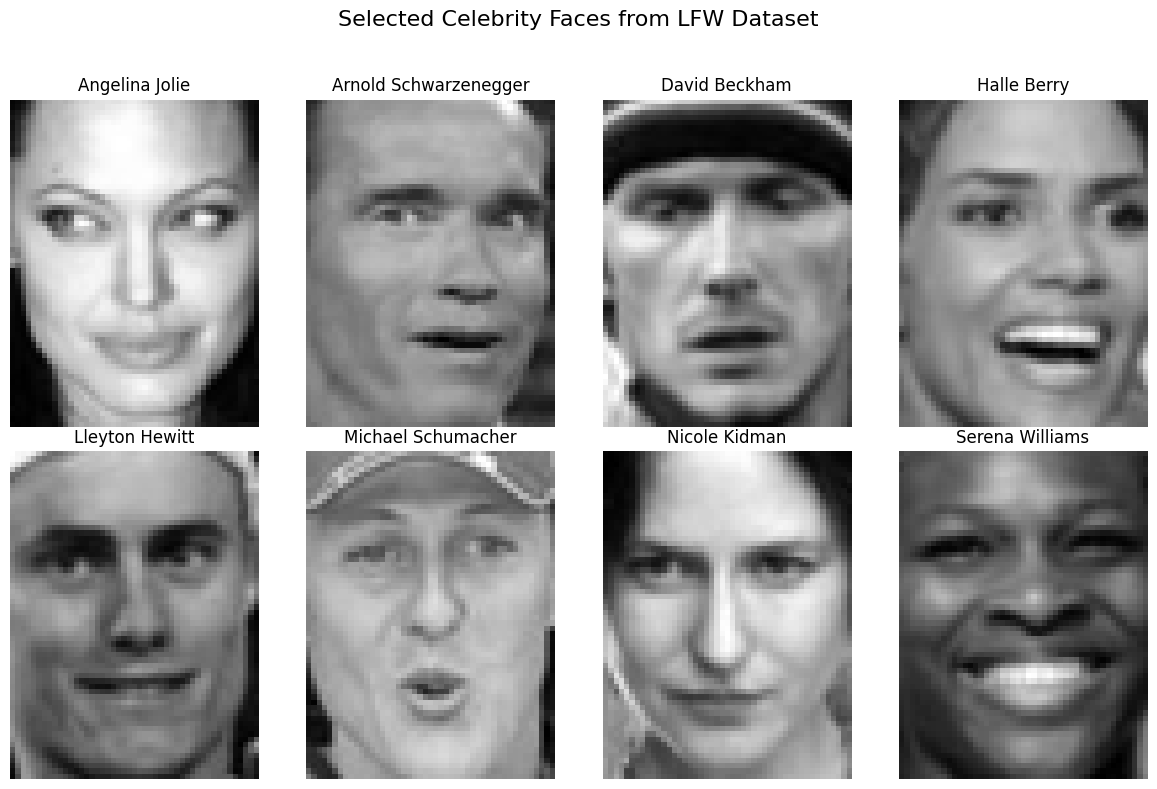

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people

# Names to select
selected_names = [
    'Angelina Jolie',
    'Arnold Schwarzenegger',
    'David Beckham',
    'Halle Berry',
    'Lleyton Hewitt',
    'Michael Schumacher',
    'Nicole Kidman',
    'Serena Williams'
]

# Find indices of the selected people in target_names
selected_indices = [np.where(target_names == name)[0][0] for name in selected_names]

# For each selected person, randomly pick one image index
rng = np.random.default_rng(seed=42)
chosen_images = []
for idx in selected_indices:
    person_image_indices = np.where(targets == idx)[0]
    chosen_idx = rng.choice(person_image_indices)
    chosen_images.append((selected_names[selected_indices.index(idx)], images[chosen_idx]))

# Plot images in grid
n = 2  # rows
m = 4  # cols
plt.figure(figsize=(3 * m, 4 * n))

for i, (name, img) in enumerate(chosen_images):
    ax = plt.subplot(n, m, i + 1)
    ax.imshow(img, cmap='gray')
    ax.set_title(name, fontsize=12)
    ax.axis('off')

plt.suptitle("Selected Celebrity Faces from LFW Dataset", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


**3. Now let's run PCA**

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

# Sacling data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Compute PCA with all possible components
max_components = min(n_samples, X_scaled.shape[1])
pca_full = PCA(n_components=max_components, svd_solver='randomized', whiten=True, random_state=42)
X_pca_full = pca_full.fit_transform(X_scaled)

**4. Now let's visualize a few of the leading PCs**

Remember how we found that our PCs in the example above were linear combinations of the input features? In this case we expect to see the same thing -- our PCs are going to be combinations of the various pixel intensities that make up our image.

The neat thing about analyzing image data is that the PCs themselves (i.e., the mixing coefficients by which the pixel intensities are combined) are themselves viewable as images. Since PCA works using a mathematical technique known as eigenvalue decomposition, these have become known in the field as "eigenfaces"!

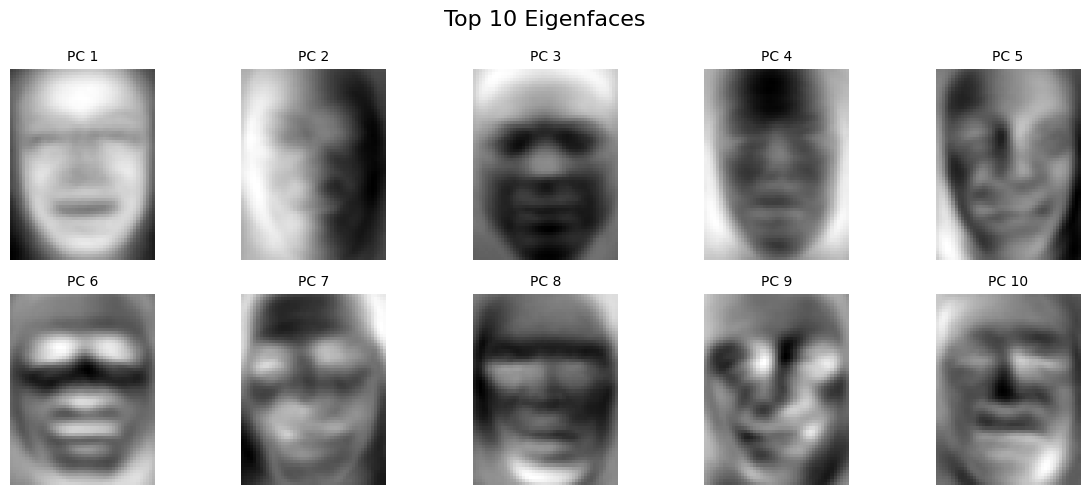

In [ ]:
import matplotlib.pyplot as plt

n_eigenfaces = 10
eigenfaces = pca_full.components_[:n_eigenfaces].reshape((n_eigenfaces, h, w))

plt.figure(figsize=(12, 5))

cols = 5
rows = 2

for i in range(n_eigenfaces):
    ax = plt.subplot(rows, cols, i + 1)
    ax.imshow(eigenfaces[i], cmap='gray')
    ax.axis('off')
    ax.set_title(f'PC {i+1}', fontsize=10)

plt.suptitle("Top 10 Eigenfaces", fontsize=16)
plt.tight_layout()
plt.show()


**5. Let's plot the culumative variance explained as a function of the number of retained PCs.**

By doing so we can determine how we wish to trade off compression (i.e., few PCs or "eigenfaces" retained in the dimensionality reduction) against information preservation (i.e., fraction of variance captured within that reduced dimensional projection).

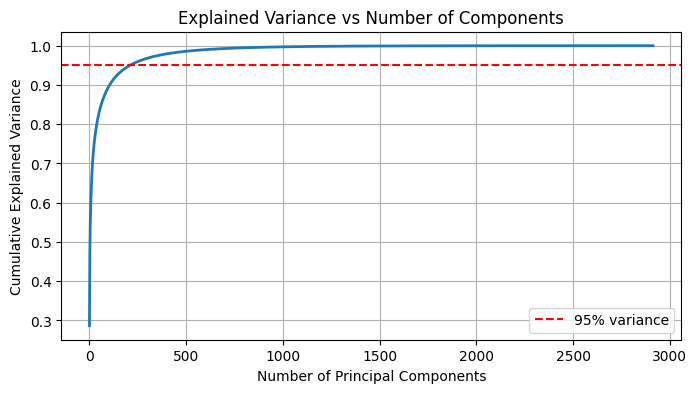

Number of PCs needed for 80% variance: 39
Number of PCs needed for 90% variance: 105
Number of PCs needed for 95% variance: 210
Number of PCs needed for 99% variance: 600


In [ ]:
# Cumulative variance
cum_var = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(8, 4))
plt.plot(cum_var, lw=2)
plt.axhline(0.95, color='r', linestyle='--', label='95% variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs Number of Components')
plt.legend()
plt.grid(True)
plt.show()

n_needed_80 = np.searchsorted(cum_var, 0.80) + 1
print(f"Number of PCs needed for 80% variance: {n_needed_80}")
n_needed_90 = np.searchsorted(cum_var, 0.90) + 1
print(f"Number of PCs needed for 90% variance: {n_needed_90}")
n_needed_95 = np.searchsorted(cum_var, 0.95) + 1
print(f"Number of PCs needed for 95% variance: {n_needed_95}")
n_needed_99 = np.searchsorted(cum_var, 0.99) + 1
print(f"Number of PCs needed for 99% variance: {n_needed_99}")


**6. Finally, let's do some compression/decompression.**

Remember how we discussed that dimensionality can be useful for storing and sending information at lower memory cost of file size? We can use PCA to make a compressed representation of each image, perhaps send it over email at much lower data transmission cost, and then our recipient can reconstruct the image within the basis of PCs.

Let's see how accurately we can reconstruct each image for different numbers of PCs. We are testing how "lossy" our compression/decompression algorithm is in preserving the important features and information in the image.

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import ipywidgets as widgets
import numpy as np

# List of selected people
selected_people = [
    'Angelina Jolie',
    'Arnold Schwarzenegger',
    'David Beckham',
    'Halle Berry',
    'Lleyton Hewitt',
    'Michael Schumacher',
    'Nicole Kidman',
    'Serena Williams'
]

# Find one image index per selected person
selected_indices = []
for person in selected_people:
    idx = np.where(lfw.target_names[lfw.target] == person)[0]
    if len(idx) > 0:
        selected_indices.append(idx[0])
    else:
        print(f"Warning: {person} not found in dataset")

def interactive_pca_reconstruction(n_components=50):
    clear_output(wait=True)

    # Fit PCA with n_components
    pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True, random_state=42)
    X_pca = pca.fit_transform(X_scaled)
    X_reconstructed = pca.inverse_transform(X_pca)
    images_reconstructed = scaler.inverse_transform(X_reconstructed).reshape((n_samples, h, w))

    n_selected = len(selected_indices)
    plt.figure(figsize=(12, 4))

    for i, idx in enumerate(selected_indices):
        # Original image
        plt.subplot(2, n_selected, i + 1)
        plt.imshow(images[idx], cmap='gray')
        plt.title(f"{lfw.target_names[lfw.target[idx]]}\nOriginal", fontsize=10)
        plt.axis('off')

        # Reconstructed image
        plt.subplot(2, n_selected, n_selected + i + 1)
        plt.imshow(images_reconstructed[idx], cmap='gray')
        plt.title(f"Reconstructed", fontsize=10)
        plt.axis('off')

    plt.suptitle(f"Reconstruction of Selected Faces with {n_components} PCs", fontsize=16)
    plt.tight_layout()
    plt.show()

    # Compression ratio = reduced dim / original dim
    compression_ratio = n_components / X.shape[1]
    explained_variance = np.sum(pca.explained_variance_ratio_)

    print(f"Compression ratio (reduced dim / original dim): {compression_ratio:.2%}")
    print(f"Variance explained by {n_components} PCs: {explained_variance:.2%}")

# Interactive slider widget
slider = widgets.IntSlider(
    value=50,
    min=1,
    max=250,#min(n_samples, X_scaled.shape[1]),
    step=1,
    description='Number PCs:',
    continuous_update=False,
    style={'description_width': 'initial'}
)

widgets.interact(interactive_pca_reconstruction, n_components=slider)


interactive(children=(IntSlider(value=50, continuous_update=False, description='Number PCs:', max=250, min=1, …

<function __main__.interactive_pca_reconstruction(n_components=50)>

## Other Dimensionality Reduction Algorithms

The scikit-learn library contains many other unsupervised dimensionality reduction routines. Here are a few popular ones:

- [sklearn.decomposition.PCA](http://scikit-learn.org/0.13/modules/generated/sklearn.decomposition.PCA.html):     
Principal Component Analysis (PCA).
- [sklearn.decomposition.RandomizedPCA](http://scikit-learn.org/0.13/modules/generated/sklearn.decomposition.RandomizedPCA.html):  
Extremely fast approximate PCA implementation based on a randomized algorithm.
- [sklearn.decomposition.SparsePCA](http://scikit-learn.org/0.13/modules/generated/sklearn.decomposition.SparsePCA.html):  
PCA variant including L1 penalty for sparsity.
- [sklearn.decomposition.FastICA](http://scikit-learn.org/0.13/modules/generated/sklearn.decomposition.FastICA.html):  
Independent Component Analysis (ICA).
- [sklearn.decomposition.NMF](http://scikit-learn.org/0.13/modules/generated/sklearn.decomposition.NMF.html):  
Non-negative Matrix Factorization (NMF).
- [sklearn.manifold.LocallyLinearEmbedding](http://scikit-learn.org/0.13/modules/generated/sklearn.manifold.LocallyLinearEmbedding.html):  
Locally linear embedding (LLE) nonlinear manifold learning based on local neighborhood geometry.
- [sklearn.manifold.IsoMap](http://scikit-learn.org/0.13/modules/generated/sklearn.manifold.Isomap.html):  
Nonlinear manifold learning technique based on a sparse graph algorithm.
   
Each of these has its own strengths & weaknesses, and areas of application. You can read about them on the [scikit-learn website](http://sklearn.org).



---



# Unsupervised Clustering w/ K-Means

We recall that k-means is an algorithm for **unsupervised clustering**. Our data do not have labels, so we are seeking to understand if there is some underlying structure in the data in terms of the emergence of clusters. We wish to allow the data to "speak for itself".

K-means is a relatively easy-to-understand algorithm.  It searches for cluster centers which are the mean of the points within them, such that every point is closest to the cluster center it is assigned to.

## Data Exploration

Let's start by taking a look at a simple 2D dataset that contains 4 clusters that are easily detectable by eye.

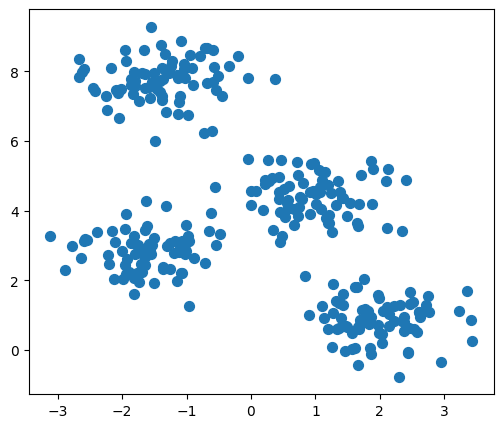

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], s=50);

## K-Means

By eye, it is relatively easy to pick out the four clusters.

For a computer, an exhaustive search of all possible different partitionings of the 300 data points would be extremely slow and ineficient.

Fortunately, k-means can be solved (approximately) using an  *expectation-maximization (EM)* procedure which you can think of as operating conceptually similar to gradient descent.

1. We guess some initial points to serve as our $k$ cluster centers ("centroid").
2. We assign all points to their nearest centroid to define our clusters.
3. We update the cluster centroids by taking the mean over all points assigned to each cluster.
4. We repeat steps 2 and 3 until convergence (i.e., the cluster assignments no longer change).

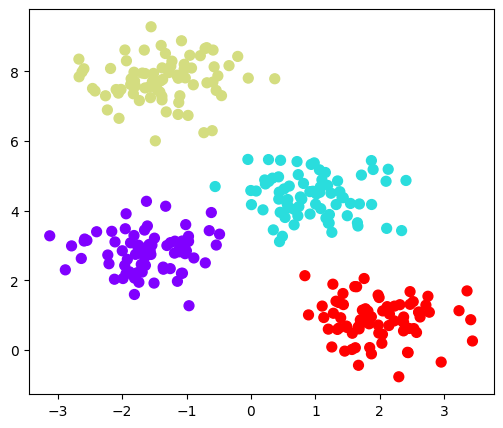

In [ ]:
from sklearn.cluster import KMeans
est = KMeans(4)  # 4 clusters
est.fit(X)
y_kmeans = est.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='rainbow');

The algorithm identifies the four clusters of points in a manner very similar to what we would do by eye!

## Visualizing K-Means in Action

Let's visualize the k-means algorithm in action.

In [ ]:
# Step 1: Setup
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
import ipywidgets as widgets

# Step 2: Generate synthetic data
X, y_true = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)

# Step 3: K-means with history tracking (no trails)
def kmeans_with_history(X, k, seed=42, max_iter=20):
    rng = np.random.default_rng(seed)
    centroids = X[rng.choice(X.shape[0], size=k, replace=False)]
    history = []

    for _ in range(max_iter):
        # E-step: Assign clusters
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)

        # Record state
        history.append((centroids.copy(), labels.copy()))

        # M-step: Update centroids
        new_centroids = np.array([X[labels == j].mean(axis=0) for j in range(k)])

        # Stop if converged
        if np.allclose(centroids, new_centroids):
            break

        centroids = new_centroids

    return history

# Step 4: Animation function
def animate_kmeans(k, seed):
    history = kmeans_with_history(X, k, seed)
    fig, ax = plt.subplots(figsize=(6, 6))
    colors = plt.cm.tab10.colors

    def update(i):
        ax.clear()
        centroids, labels = history[i]
        for cluster_id in range(k):
            points = X[labels == cluster_id]
            ax.scatter(points[:, 0], points[:, 1], s=30, color=colors[cluster_id % 10], label=f"Cluster {cluster_id}")
            ax.scatter(*centroids[cluster_id], marker='X', color='black', s=200, edgecolor='white')

        ax.set_title(f"K-Means Iteration {i + 1}")
        ax.set_xlim(X[:, 0].min() - 1, X[:, 0].max() + 1)
        ax.set_ylim(X[:, 1].min() - 1, X[:, 1].max() + 1)
        ax.legend(loc='best')

    ani = FuncAnimation(fig, update, frames=len(history), interval=1000, repeat=True)
    plt.close()
    display(HTML(ani.to_jshtml()))

# Step 5: Interactive interface using value input boxes
k_input = widgets.BoundedIntText(
    value=4,
    min=1,
    max=10,
    step=1,
    description='Number of clusters, k =',
    style={'description_width': 'initial'}
)

seed_input = widgets.IntText(
    value=42,
    description='Random number seed =',
    style={'description_width': 'initial'}
)

ui = widgets.VBox([k_input, seed_input])
out = widgets.interactive_output(animate_kmeans, {'k': k_input, 'seed': seed_input})
display(ui, out)


Output()

Re-run the code to explore what happens for different choices of $k$ and the random seed used to initialize the initial guess for our centroids.

* Do you always get the same results for different random seeds?
* How do we know how to choose a good $k$?

The convergence of k-means is not guaranteed, and for that reason `sklearn` by default uses a large number of random initializations and finds the best results.

The value of $k$ is a **hyperparameter**, the number of clusters must be set by the user beforehand and is not learned from the data. There are other clustering algorithms for which $k$ can be learned requirement may be lifted.

## Choosing $k$ via Silhouette Score

One way to help us choose $k$ is to determine how well the points have been clustered after learning is complete. One way to do this is by computing the **silhouette score**.

We compute the silhouette score as follows:

1. Compute for each point the intra-cluster distance $a$ -- this is the average distance to all other points within the same cluster and represents how well the point fits into its own cluster.

2. Compute for each point the nearest-cluster distance $b$ -- this is the average distance from the point to all points in its nearest neighboring cluster and represents how well the point fits into the other cluster, not its assigned one.

3. Compute for each point the silhouette score $(b - a) / max(a, b)$:
* $+1$: Ideal clustering, where each point is far from other clusters and close to its own.
* $0$: The point is close to the decision boundary between two clusters.
* $-1$: The point is likely misclassified and should be in another cluster.

4. Average the silhouette scores over all points.

By graphing the average silhouette score as a function of $k$, we can try to identify an optimal number of clusters by identifying a **global maximum**, a **local maximum** or a **shoulder/knee**.

Let's try it.

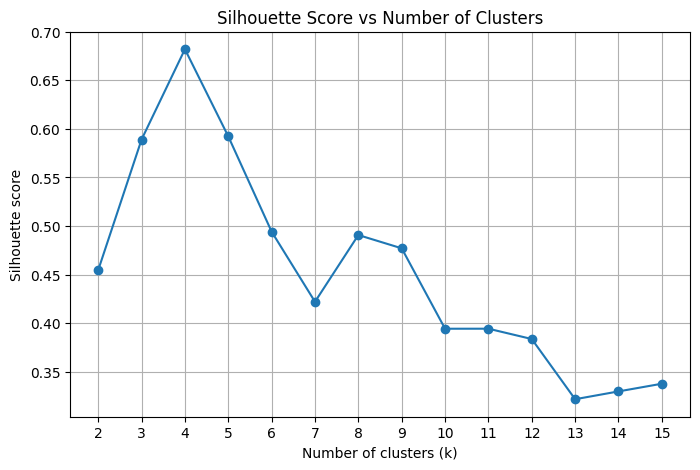

Best k by silhouette score: 4 (score = 0.682)


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# Range of k values to test
k_values = range(2, 16)
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title("Silhouette Score vs Number of Clusters")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.xticks(k_values)
plt.grid(True)
plt.show()

# Print best k
best_k = k_values[np.argmax(silhouette_scores)]
print(f"Best k by silhouette score: {best_k} (score = {max(silhouette_scores):.3f})")


## PCA + K-Means Clustering -- AT&T Faces Data

Of course k-means can be applied to much higher dimensional datasets with much larger numbers of clusters. (Although visualization becomes much more difficult.)

One profitable and common way to perform unsupervised data exploration and analysis is to combine PCA dimensionality reduction -- to help simplify the data, extract its inherent structure, and suppress noise -- with k-means clustering -- to extract clusters within the data.

Let's do so for the AT&T faces data set.

> Credit: AT&T Laboratories Cambridge [https://cam-orl.co.uk/facedatabase.html](https://cam-orl.co.uk/facedatabase.html)


**1. Let's import the data.**

✅ Loaded 400 images with 2576 features each (flattened 56x46)
👤 Number of unique people: 40


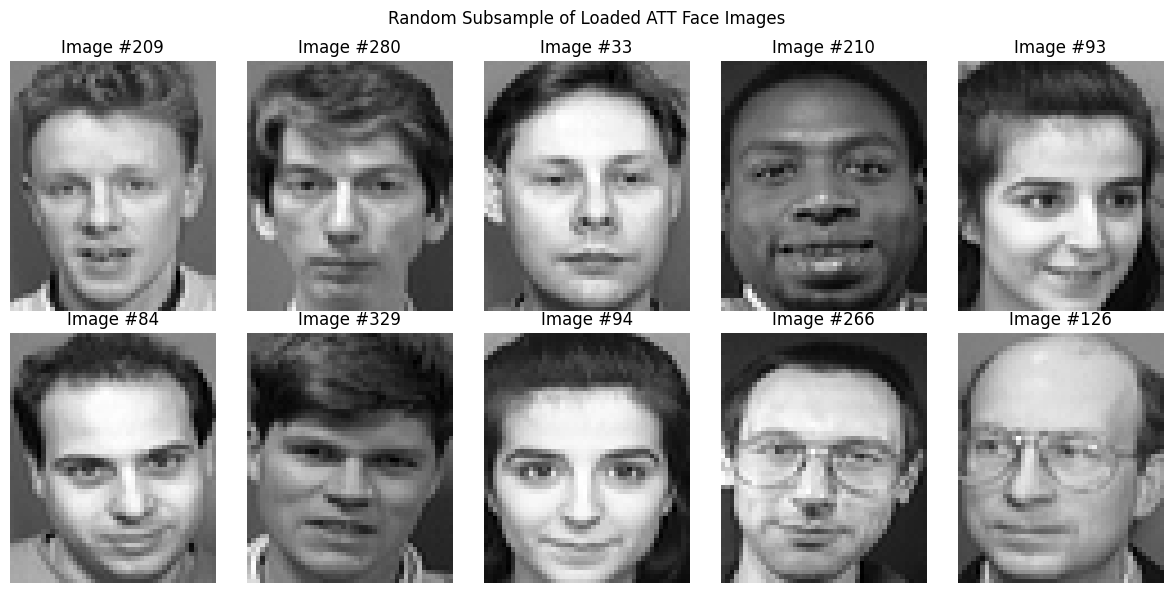

In [ ]:
import requests
import numpy as np
from PIL import Image, UnidentifiedImageError
from io import BytesIO
import matplotlib.pyplot as plt

# Step 1: Load list of image paths
url_list = "https://raw.githubusercontent.com/andrewlferguson/MENG15100/main/data/att_faces/att_faces_image_files.txt"
response = requests.get(url_list)
raw_paths = response.text.strip().split("\n")

# Step 2: Clean paths to remove duplicated base prefix
image_paths = [p.replace("data/att_faces/", "") for p in raw_paths]

# Step 3: Set target size (downscale to 46x56)
target_size = (46, 56)  # (width, height)

# Step 4: Load, resize, and flatten images into vector format
base_url = "https://raw.githubusercontent.com/andrewlferguson/MENG15100/main/data/att_faces/"
images = []
labels = []

for path in image_paths:
    full_url = base_url + path
    try:
        img_response = requests.get(full_url)
        img = Image.open(BytesIO(img_response.content)).convert("L")  # grayscale
        img = img.resize(target_size, Image.LANCZOS)  # high-quality downsampling
        img_array = np.array(img)
        images.append(img_array.flatten())  # flatten 2D image to 1D vector

        label = path.split("/")[0]  # e.g., 's1', 's2', etc.
        labels.append(label)

    except UnidentifiedImageError:
        print(f"❌ Could not identify image file at: {full_url}")
    except Exception as e:
        print(f"❌ Error loading {full_url}: {e}")

# Step 5: Convert lists to arrays
X = np.array(images)        # shape (n_samples, width*height)
labels = np.array(labels)

n_samples, n_features = X.shape
print(f"✅ Loaded {n_samples} images with {n_features} features each (flattened {target_size[1]}x{target_size[0]})")
print(f"👤 Number of unique people: {len(np.unique(labels))}")

# Step 6: Show random samples (reshaped back to image shape)
num_samples_to_show = 10
np.random.seed(42)
random_indices = np.random.choice(n_samples, size=num_samples_to_show, replace=False)

plt.figure(figsize=(12, 6))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[idx].reshape(target_size[1], target_size[0]), cmap="gray")
    plt.title(f"Image #{idx}")
    plt.axis("off")

plt.suptitle("Random Subsample of Loaded ATT Face Images")
plt.tight_layout()
plt.show()

**2. Now let's run PCA and keep a number of PCs to preserve 95% of the variance.**

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit PCA to capture n% of variance
pca = PCA(n_components=0.99, svd_solver='full', whiten=True, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"PCA reduced data from {X_scaled.shape[1]} to {X_pca.shape[1]} dimensions.")


PCA reduced data from 2576 to 290 dimensions.


**3. Now we will run k-means clustering and silhouette score analysis.**

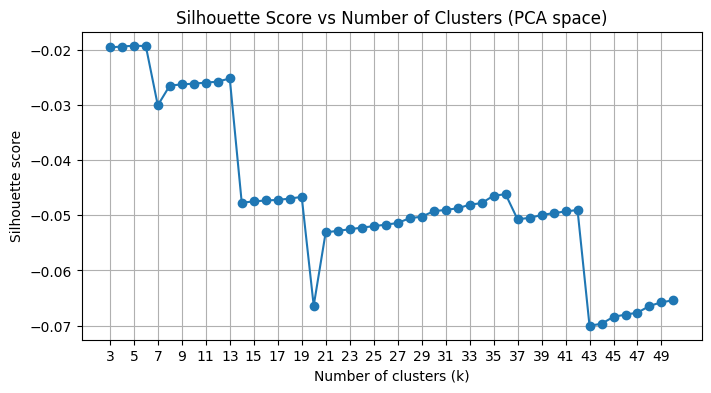

Best k by silhouette score: 5


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

silhouette_scores = []
k_range = range(3, 51)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.figure(figsize=(8, 4))
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.title("Silhouette Score vs Number of Clusters (PCA space)")
plt.grid(True)
plt.xticks(range(k_range.start, k_range.stop, 2))
plt.show()

# Select best k
best_k = k_range[np.argmax(silhouette_scores)]
print(f"Best k by silhouette score: {best_k}")


In [ ]:
best_k = 36

**4. Perform k-means clustering at optimal $k$.**

In [ ]:
kmeans = KMeans(n_clusters=best_k, random_state=42)
cluster_labels = kmeans.fit_predict(X_pca)

unique, counts = np.unique(cluster_labels, return_counts=True)
print("\nCluster membership counts:")
for cluster_id, count in zip(unique, counts):
    print(f"Cluster {cluster_id}: {count}")



Cluster membership counts:
Cluster 0: 4
Cluster 1: 27
Cluster 2: 3
Cluster 3: 3
Cluster 4: 1
Cluster 5: 1
Cluster 6: 12
Cluster 7: 2
Cluster 8: 2
Cluster 9: 1
Cluster 10: 3
Cluster 11: 2
Cluster 12: 12
Cluster 13: 1
Cluster 14: 1
Cluster 15: 5
Cluster 16: 29
Cluster 17: 3
Cluster 18: 29
Cluster 19: 213
Cluster 20: 1
Cluster 21: 1
Cluster 22: 1
Cluster 23: 1
Cluster 24: 1
Cluster 25: 1
Cluster 26: 1
Cluster 27: 3
Cluster 28: 25
Cluster 29: 3
Cluster 30: 1
Cluster 31: 1
Cluster 32: 2
Cluster 33: 1
Cluster 34: 2
Cluster 35: 1


**5. Show some illustrative images from each cluster.**

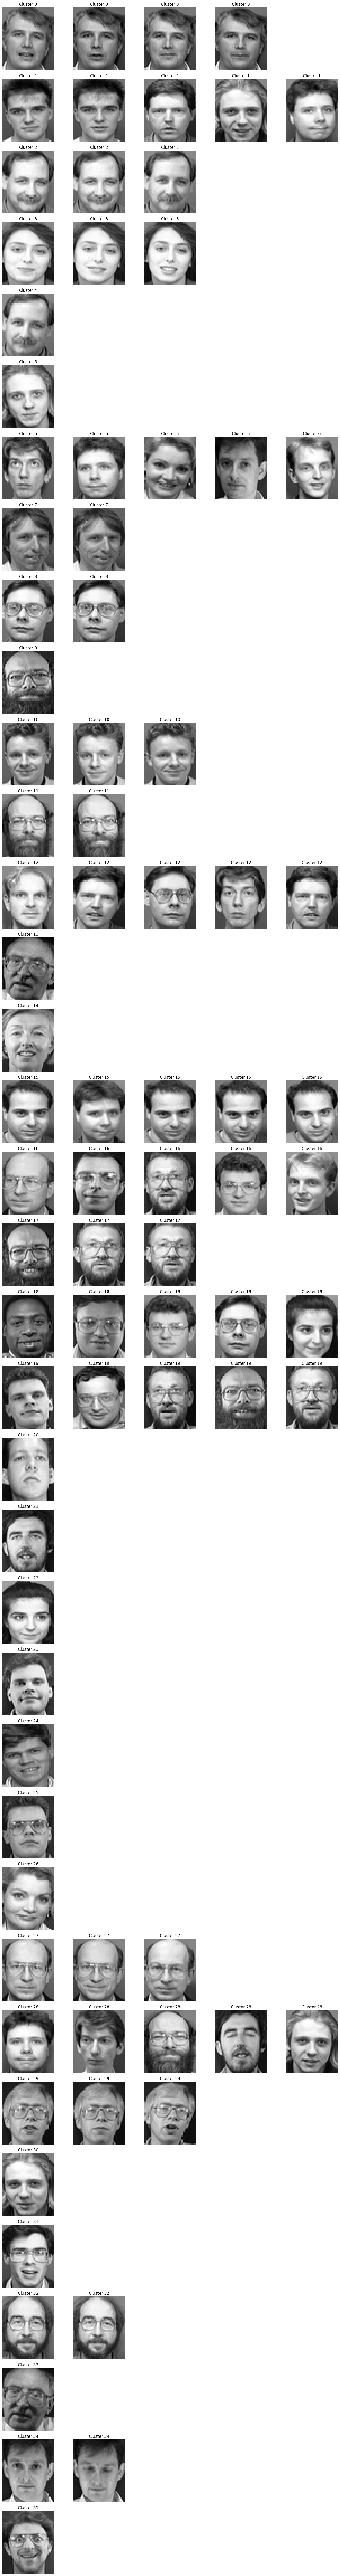

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

num_clusters = len(np.unique(cluster_labels))
max_per_cluster = 5

plt.figure(figsize=(max_per_cluster * 3, num_clusters * 3))

for cluster_id in range(num_clusters):
    # Get indices of images in this cluster
    cluster_indices = np.where(cluster_labels == cluster_id)[0]

    # Randomly sample up to 5 images from this cluster
    sample_size = min(max_per_cluster, len(cluster_indices))
    sampled_indices = np.random.choice(cluster_indices, size=sample_size, replace=False)

    for i, img_idx in enumerate(sampled_indices):
        plt_idx = cluster_id * max_per_cluster + i + 1
        plt.subplot(num_clusters, max_per_cluster, plt_idx)
        plt.imshow(X[img_idx].reshape(target_size[1], target_size[0]), cmap='gray')
        plt.title(f"Cluster {cluster_id}")
        plt.axis('off')

plt.tight_layout()
plt.show()


## Other Clustering Algorithms

The scikit-learn library contains a variety of unsupervised clustering algorithms. Here are a few popular ones:

- [`sklearn.cluster.KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html):  
  Classic centroid-based clustering using the k-means algorithm.

- [`sklearn.cluster.MiniBatchKMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html):  
  Faster, approximate version of KMeans suitable for large datasets.

- [`sklearn.cluster.DBSCAN`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html):  
  Density-based clustering that can find arbitrarily shaped clusters and outliers.

- [`sklearn.cluster.AgglomerativeClustering`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html):  
  Hierarchical clustering using bottom-up agglomeration.

- [`sklearn.cluster.MeanShift`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html):  
  Clustering based on kernel density estimation and mode seeking.

- [`sklearn.cluster.SpectralClustering`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html):  
  Graph-based clustering method using the spectrum (eigenvalues) of a similarity matrix.

- [`sklearn.cluster.Birch`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.Birch.html):  
  Balanced Iterative Reducing and Clustering using Hierarchies; designed for large datasets.

- [`sklearn.mixture.GaussianMixture`](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html):  
  Probabilistic model-based clustering using Gaussian Mixture Models (GMMs).

Each of these algorithms has different assumptions, advantages, and use cases. You can learn more about them and see usage examples on the [official scikit-learn website](https://scikit-learn.org/stable/modules/clustering.html).
